In [1]:
try:
  %tensorflow_version 2.x
except:
  pass

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import operator
from PIL import Image
import tensorflow as tf
from keras.models import model_from_json
from skimage.segmentation import clear_border
from matplotlib.pyplot import imshow,show
from keras.models import load_model
import operator
import copy

In [3]:
def display_rects(in_img, rects, colour=255):
	"""Displays rectangles on the image."""
	img = in_img.copy()
	for rect in rects:
		img = cv2.rectangle(img, tuple(int(x) for x in rect[0]), tuple(int(x) for x in rect[1]), colour)
	show_image(img)
	return img

In [4]:
def show_image(img):
	imshow(img,cmap = 'gray')

In [5]:
def show_digits(digits, colour=255):
	"""Shows list of 81 extracted digits in a grid format"""
	rows = []
	with_border = [cv2.copyMakeBorder(img.copy(), 1, 1, 1, 1, cv2.BORDER_CONSTANT, None, colour) for img in digits]
	for i in range(9):
		row = np.concatenate(with_border[i * 9:((i + 1) * 9)], axis=1)
		rows.append(row)
	return np.concatenate(rows)

In [6]:
def pre_process_image(img, skip_dilate=False):

    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

	# Gaussian blur with a kernal size (height, width) of 9.
	# Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)    

	# Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

	# Invert colours, so gridlines have non-zero pixel values.
	# Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)
    if not skip_dilate:
       kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],dtype=np.uint8)
       proc = cv2.dilate(proc, kernel)

    return proc

In [7]:
def cut_from_rect(img, rect):
	"""Cuts a rectangle from an image using the top left and bottom right points."""
	return img[int(rect[0][1]):int(rect[1][1]),int(rect[0][0]):int(rect[1][0])]	

In [8]:
def find_corners_of_largest_polygon(img):
	"""Finds the 4 extreme corners of the largest contour in the image."""
	contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
	contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
	polygon = contours[0]  # Largest image

	# Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
	# Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

	# Bottom-right point has the largest (x + y) value
	# Top-left has point smallest (x + y) value
	# Bottom-left point has smallest (x - y) value
	# Top-right point has largest (x - y) value
	bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
	top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
	bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
	top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

	# Return an array of all 4 points using the indices
	# Each point is in its own array of one coordinate
	return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]


In [9]:
def distance_between(p1, p2):
	"""Returns the scalar distance between two points"""
	a = p2[0] - p1[0]
	b = p2[1] - p1[1]
	return np.sqrt((a ** 2) + (b ** 2))

In [10]:
def crop_and_warp(img, crop_rect):
	"""Crops and warps a rectangular section from an image into a square of similar size."""

	# Rectangle described by top left, top right, bottom right and bottom left points
	top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

	# Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
	src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

	# Get the longest side in the rectangle
	side = max([
		distance_between(bottom_right, top_right),
		distance_between(top_left, bottom_left),
		distance_between(bottom_right, bottom_left),
		distance_between(top_left, top_right)
	])

	# Describe a square with side of the calculated length, this is the new perspective we want to warp to
	dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

	# Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
	m = cv2.getPerspectiveTransform(src, dst)

	# Performs the transformation on the original image
	return cv2.warpPerspective(img, m, (int(side), int(side)))

In [11]:
def infer_grid(img):
	"""Infers 81 cell grid from a square image."""
	squares = []
	side = img.shape[:1]
	side = side[0] / 9
	for j in range(9):
		for i in range(9):
			p1 = (i * side, j * side)  # Top left corner of a bounding box
			p2 = ((i + 1) * side, (j + 1) * side)  # Bottom right corner of bounding box
			squares.append((p1, p2))
	return squares

In [12]:
def scale_and_centre(img, size, margin=0, background=0):
	"""Scales and centres an image onto a new background square."""
	h, w = img.shape[:2]

	def centre_pad(length):
		"""Handles centering for a given length that may be odd or even."""
		if length % 2 == 0:
			side1 = int((size - length) / 2)
			side2 = side1
		else:
			side1 = int((size - length) / 2)
			side2 = side1 + 1
		return side1, side2

	def scale(r, x):
		return int(r * x)

	if h > w:
		t_pad = int(margin / 2)
		b_pad = t_pad
		ratio = (size - margin) / h
		w, h = scale(ratio, w), scale(ratio, h)
		l_pad, r_pad = centre_pad(w)
	else:
		l_pad = int(margin / 2)
		r_pad = l_pad
		ratio = (size - margin) / w
		w, h = scale(ratio, w), scale(ratio, h)
		t_pad, b_pad = centre_pad(h)

	img = cv2.resize(img, (w, h))
	img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
	return cv2.resize(img, (size, size))

In [13]:
def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
	"""
	Uses the fact the `floodFill` function returns a bounding box of the area it filled to find the biggest
	connected pixel structure in the image. Fills this structure in white, reducing the rest to black.
	"""
	img = inp_img.copy()  # Copy the image, leaving the original untouched
	height, width = img.shape[:2]

	max_area = 0
	seed_point = (None, None)

	if scan_tl is None:
		scan_tl = [0, 0]

	if scan_br is None:
		scan_br = [width, height]

	# Loop through the image
	for x in range(scan_tl[0], scan_br[0]):
		for y in range(scan_tl[1], scan_br[1]):
			# Only operate on light or white squares
			if img.item(y, x) == 255 and x < width and y < height:  # Note that .item() appears to take input as y, x
				area = cv2.floodFill(img, None, (x, y), 64)
				if area[0] > max_area:  # Gets the maximum bound area which should be the grid
					max_area = area[0]
					seed_point = (x, y)

	# Colour everything grey (compensates for features outside of our middle scanning range
	for x in range(width):
		for y in range(height):
			if img.item(y, x) == 255 and x < width and y < height:
				cv2.floodFill(img, None, (x, y), 64)

	mask = np.zeros((height + 2, width + 2), np.uint8)  # Mask that is 2 pixels bigger than the image

	# Highlight the main feature
	if all([p is not None for p in seed_point]):
		cv2.floodFill(img, mask, seed_point, 255)

	top, bottom, left, right = height, 0, width, 0

	for x in range(width):
		for y in range(height):
			if img.item(y, x) == 64:  # Hide anything that isn't the main feature
				cv2.floodFill(img, mask, (x, y), 0)

			# Find the bounding parameters
			if img.item(y, x) == 255:
				top = y if y < top else top
				bottom = y if y > bottom else bottom
				left = x if x < left else left
				right = x if x > right else right

	bbox = [[left, top], [right, bottom]]
	return img, np.array(bbox, dtype='float32'), seed_point

In [14]:
def get_digits(img, squares, size):
	"""Extracts digits from their cells and builds an array"""
	digits = []
	img = pre_process_image(img.copy(), skip_dilate=True)
	for square in squares:
		digits.append(extract_digit(img, square, size))
	return digits

In [15]:
def extract_digit(img, rect, size):
	"""Extracts a digit (if one exists) from a Sudoku square."""

	digit = cut_from_rect(img, rect)  # Get the digit box from the whole square

	# Use fill feature finding to get the largest feature in middle of the box
	# Margin used to define an area in the middle we would expect to find a pixel belonging to the digit
	h, w = digit.shape[:2]
	margin = int(np.mean([h, w]) / 2.5)
	_, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
	digit = cut_from_rect(digit, bbox)

	# Scale and pad the digit so that it fits a square of the digit size we're using for machine learning
	w = bbox[1][0] - bbox[0][0]
	h = bbox[1][1] - bbox[0][1]

	# Ignore any small bounding boxes
	if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
		return scale_and_centre(digit, size, 4)
	else:
		return np.zeros((size, size), np.uint8)

In [16]:
def getEveryDigits(img,squares):
    labels = []
    model = tf.keras.models.load_model('./digit_classifier.h5')
    img2 = cv2.medianBlur(img.copy(),5)
    img2 = cv2.adaptiveThreshold(img2,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)

    img2 = cv2.bitwise_not(img2, img2)
    for square in squares:
        digit = extract_digit(img2, square, 28)
        '''imshow(digit,cmap = 'gray')
        show()'''
        
        numPixels = cv2.countNonZero(digit)
        if numPixels<80:
            labels.append(0)
        else:
            digit = np.argmax(model.predict(digit.reshape(-1,28,28,1))[0])    
            labels.append(1+ digit)
    return matrix_convert(labels)

In [17]:
def matrix_convert(label):
    a=0
    matrix=[]
    for i in range(0,9):
        matrix.append(label[a:a+9])
        a=a+9
    for i in range(0,9):
        print(matrix[i])
    return matrix

In [18]:
def checkGrid(grid):
  for row in range(0,9):
      for col in range(0,9):
        if grid[row][col]==0:
          return False
  return True

In [19]:
#Backtracking algorithm
def solveGrid(grid):

  for i in range(0,81):
    row=int(i/9)
    col=int(i%9)
    if grid[row][col]==0:
      for value in range (1,10):
        if not(value in grid[row]):
          if not value in (grid[0][col],grid[1][col],grid[2][col],grid[3][col],grid[4][col],grid[5][col],grid[6][col],grid[7][col],grid[8][col]):
            square=[]
            if row<3:
              if col<3:
                square=[grid[i][0:3] for i in range(0,3)]
              elif col<6:
                square=[grid[i][3:6] for i in range(0,3)]
              else:
                square=[grid[i][6:9] for i in range(0,3)]
            elif row<6:
              if col<3:
                square=[grid[i][0:3] for i in range(3,6)]
              elif col<6:
                square=[grid[i][3:6] for i in range(3,6)]
              else:
                square=[grid[i][6:9] for i in range(3,6)]
            else:
              if col<3:
                square=[grid[i][0:3] for i in range(6,9)]
              elif col<6:
                square=[grid[i][3:6] for i in range(6,9)]
              else:
                square=[grid[i][6:9] for i in range(6,9)]
            if not value in (square[0] + square[1] + square[2]):
              grid[row][col]=value
              if checkGrid(grid):
                print("Sudoku Result")
                for i in range(0,9):
                      print(grid[i])
                print("CHECK CONTROL ")
                return grid
              else:
                  if solveGrid(grid):
                    return grid
      break
  grid[row][col]=0

In [20]:
def writeImg(solved,old,img,squares):
    font  = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    color  = ( 0, 0, 255)
    org = (50, 50)
    thickness = 2
    img2 = cv2.medianBlur(img.copy(),5)
    img2 = cv2.adaptiveThreshold(img2,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)

    img2 = cv2.bitwise_not(img2, img2)
    for square in squares:
        write_digit = extract_digit(img2, square, 28)
        numPixels = cv2.countNonZero(write_digit)
        tp = (int(square[0][0]+20),int(square[0][1]+40))
        if numPixels<80:        
            cv2.putText(img,str(solved[int(square[0][1]/62.333333333333336)][int(square[0][0]/62.333333333333336)]),tp, font,  fontScale,color, thickness, cv2.LINE_AA)
    return img       

In [38]:
img = cv2.imread('./Puzzles/sud.jpeg', cv2.IMREAD_GRAYSCALE)

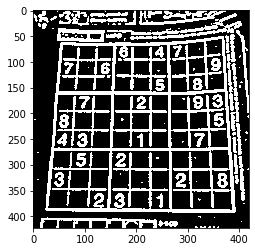

In [39]:
processed = pre_process_image(img)
show_image(processed)

In [40]:
corners = find_corners_of_largest_polygon(processed)

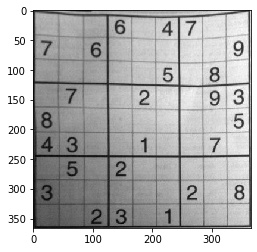

In [41]:
cropped = crop_and_warp(img, corners)
squares = infer_grid(cropped)
show_image(cropped)

In [42]:
digits = getEveryDigits(cropped, squares)

[0, 0, 0, 6, 0, 4, 7, 0, 0]
[7, 0, 6, 0, 0, 0, 0, 0, 9]
[0, 0, 0, 0, 0, 5, 0, 8, 0]
[0, 7, 0, 0, 2, 0, 0, 9, 3]
[8, 0, 0, 0, 0, 0, 0, 0, 5]
[4, 3, 0, 0, 1, 0, 0, 7, 0]
[0, 5, 0, 2, 0, 0, 0, 0, 0]
[3, 0, 0, 0, 0, 0, 2, 0, 8]
[0, 0, 2, 3, 0, 1, 0, 0, 0]


In [26]:
solved = solveGrid(copy.deepcopy(digits))

Sudoku Result
[9, 5, 6, 4, 8, 1, 3, 2, 7]
[1, 2, 3, 6, 7, 9, 5, 4, 8]
[7, 4, 8, 2, 5, 3, 6, 1, 9]
[8, 3, 2, 1, 9, 5, 7, 6, 4]
[6, 7, 9, 3, 4, 2, 8, 5, 1]
[5, 1, 4, 8, 6, 7, 9, 3, 2]
[3, 6, 7, 9, 2, 4, 1, 8, 5]
[2, 9, 1, 5, 3, 8, 4, 7, 6]
[4, 8, 5, 7, 1, 6, 2, 9, 3]
CHECK CONTROL 


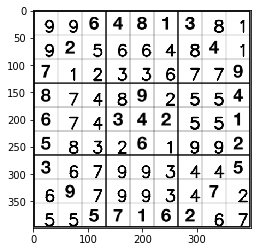

In [27]:
result = writeImg(solved,digits,cropped,squares)
show_image(result)